# TSP: MST + Eulerian circuit

## Tour Construction Heuristics
* Greedy  
  * One-way  
  * Two-way  
* Insertion  
  * Nearist insertion
  * Farthest insertion  
  * Convex hull  
    * Giftwrapping  
    * Graham scan
* MST: minimum spanning tree  
  * Kruskal  
  * Prim
* Eulerian circuit
  * Double Tree algorithm
  * Christofides algorithm 
    * Minimum-weight perfect matching M
* Resolution reduction  
* Neural Net

## Tour Improvement Heuristics
* Flip N Reverse  
* One Insertion  
* Two Insertion  
* K-opt

## Python Libraries  
* pyconcorde: https://github.com/jvkersch/pyconcorde  (approximation algorithm: Chained Lin-Kernighan)
* networkx: https://networkx.github.io/documentation/stable/index.html 

## Libraries

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from tqdm import tqdm_notebook as tqdm
from concorde.tsp import TSPSolver
import networkx as nx
#from numba import jit, njit, prange
seed = 43
np.random.seed(seed=seed)

In [2]:
def gen_param(num):
    path = np.concatenate([np.arange(num), [0]])
    X = np.random.random(num)
    Y = np.random.random(num)
    XY = X + Y * 1j
    return num, path, X, Y, XY

In [3]:
def score(path, A, B):
    c = XY[path[A: B+1]]
    sc = np.sum(np.abs(np.diff(c)))
    return sc

In [4]:
def plot_path(path, size=6):
    plt.figure(figsize=(size, size))
    cmap = plt.get_cmap("tab10")
    plt.axis('equal')
    plt.plot(X[path], Y[path], alpha=0.0)
    plt.scatter(X[0], Y[0], s=80, c='r', marker='o')
    for i in range(len(path)-1):
        plt.arrow(X[path[i]], Y[path[i]], 
                  X[path[i+1]]-X[path[i]], Y[path[i+1]]-Y[path[i]], 
                  head_width=0.02, head_length=0.02, length_includes_head=True, 
                  fc=cmap(0), ec=cmap(0))
    
    for i in range(num):
        plt.text(X[i], Y[i]+0.01, s=i, fontsize=10, color='gray')
    print('Total Score: ', score(path, 0, len(path)-1))

In [5]:
def plot_list(path, plist=False, size=6):
    plt.figure(figsize=(size, size))
    cmap = plt.get_cmap("tab10")
    plt.axis('equal')
    plt.plot(X[path], Y[path], alpha=0)
    plt.scatter(X[0], Y[0], s=80, c='r', marker='o')
    plt.scatter(X[1:], Y[1:], s=40, c=cmap(0), marker='o')
    if plist:
        for p in plist:
            plt.plot(X[p], Y[p])
    
    for i in range(num):
        plt.text(X[i], Y[i]+0.01, s=i, fontsize=10, color='gray')

Total Score:  52.8760351727298


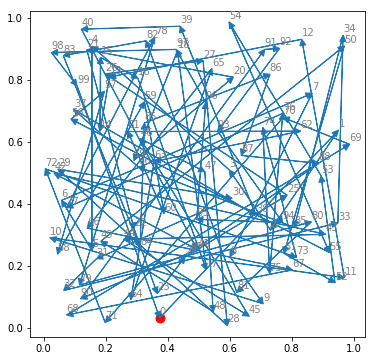

In [6]:
num, path, X, Y, XY = gen_param(100)
plot_path(path)

## MST: Minimum Spanning Tree

### Kruskal MST Algorithm 
generate MST

In [8]:
def kruskal(path):
    dist = []
    idx = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            dist.append(np.abs(XY[i] - XY[j]))
            idx.append([i,j])
    arg = np.argsort(dist)
    edge_list = [idx[a] for a in arg]
    
    plist = []
    group = []
    for edge in edge_list:
        if set(edge) & set(sum(group, [])):     # either in all groups
            merge_list = []
            for i in range(len(group)):
                if set(edge) <= set(group[i]):  # both in one group
                    continue
                elif set(edge) & set(group[i]): # either in one group
                    merge_list.append(i)
            if len(merge_list) > 0:
                group[merge_list[0]] = list(set(sum([group[m] for m in merge_list] + [edge], [])))
                [group.pop(i) for i in merge_list[1:]]
                plist.append(edge)                
        else:
            group.append(edge)
            plist.append(edge)
    return plist

def list_score(path):
    sc = 0
    for p in path:
        sc += np.abs(XY[p[0]] - XY[p[1]])
    return sc

MST Score: 6.942921687790351  Num Path: 99


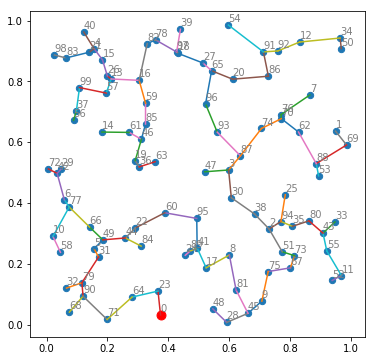

In [9]:
#num, path, X, Y, XY = gen_param(30)
edges = kruskal(path[:-1])
plot_list(path, edges, 6)
print('MST Score:', list_score(edges), ' Num Path:',len(edges))

### Prim MST Algorithm 
generate MST

MST Score: 6.942921687790348  Num Path: 99


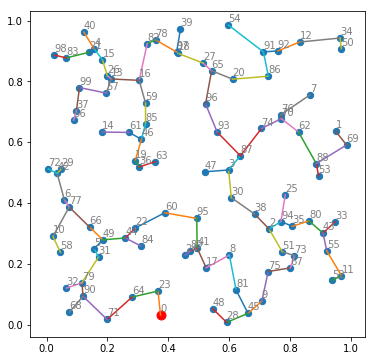

In [10]:
def nearest_node(path, index):
    best_dist = np.inf
    best_node = None
    for p in path:
        if p != index:
            d = abs(XY[p] - XY[index])
            if d < best_dist:
                best_dist = d
                best_node = p
    return best_node, best_dist

def prim(path):
    copy = list(path)
    if path[0] == path[-1]:
        copy = list(path[:-1])
    node, _ = nearest_node(copy, path[0])
    plist = [[path[0], node]]
    copy.remove(path[0])
    copy.remove(node)
    
    while len(copy):
        best_dist = np.inf
        best_edge = None
        for p in set(np.ravel(plist)):
            node, dist = nearest_node(copy, p)
            if dist < best_dist:
                best_dist = dist
                best_edge = [p, node]
        plist.append(best_edge)
        copy.remove(best_edge[1])
    return plist

edges = prim(path)
plot_list(path, edges, 6)
print('MST Score:', list_score(edges), ' Num Path:',len(edges))

### Minimum-weight Perfect Matching:  
add more edges to MST to make a Eulerian circuit 

In [25]:
def min_weight_perfect_matching(edges):
    # find odd-degree nodes from MST(edges)
    odd = []
    for i in range(num):
        cnt = 0
        for e in np.ravel(edges):
            if i == e:
                cnt += 1
        if cnt % 2 == 1:
            odd.append(i)
    #print('Odd-Degree Edges:', odd)
    
    # get combinations of edges from the odd-degree nodes
    combs = list(combinations(odd, 2))
    
    # calculate weights on the edges
    weight = [abs(XY[c[0]]-XY[c[1]]) for c in combs]
    
    # negating the weights to get minimum-weight from the max_weight_matching function
    edge_weight = [(combs[i][0], combs[i][1], {'weight': -weight[i]}) for i in range(len(combs))]
    
    # find minimum-weight perfect matching(negative max_weight_matching) by NetworkX library 
    G = nx.Graph(edge_weight)
    M = nx.max_weight_matching(G, True, 'weight')
    M = [list(m) for m in M]
    G.clear()
    return M

Odd-Degree Edges: [0, 1, 2, 3, 4, 7, 13, 14, 16, 24, 25, 29, 32, 33, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 56, 58, 63, 65, 68, 70, 72, 77, 79, 84, 87, 88, 90, 91, 94, 97, 98]
M Edges: [[24, 41], [44, 84], [40, 98], [32, 79], [50, 7], [88, 53], [42, 77], [4, 13], [16, 65], [49, 58], [52, 45], [56, 14], [1, 70], [90, 68], [33, 43], [25, 87], [3, 47], [46, 63], [2, 94], [48, 0], [72, 29], [97, 39], [91, 54]]
M Score: 2.670693406418658
MST Score: 6.942921687790348  Num Path: 99


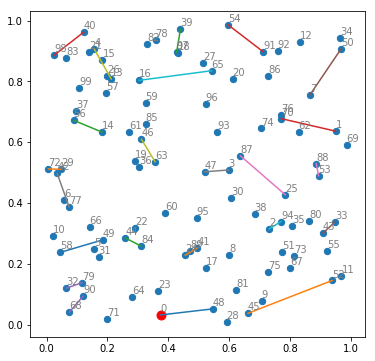

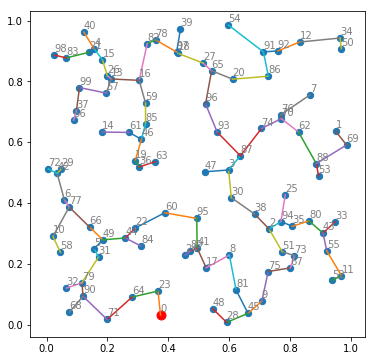

In [12]:
M = min_weight_perfect_matching(edges)
print('M Edges:', M)
print('M Score:', list_score(M))
print('MST Score:', list_score(edges), ' Num Path:',len(edges))
plot_list(path, M)
plot_list(path, edges)

## Tour Construction

In [13]:
# T, M=False: Double Tree Algorithm
# T, M=M    : Cristofides Algorithm 
def tsp_tour(T, M=False):
    if M:
        TM = (T + M).copy()
    else:
        TM = (T + T).copy()
    
    tour = [TM[0]]
    TM.remove(TM[0])

    while len(TM):
        for tm in TM:
            if tour[-1][1] == tm[0]:   # tour(n,0) == TM(0,m) 
                tour.append(tm)
                TM.remove(tm)
            elif tour[-1][1] == tm[1]: # tour(n,0) == TM(m,0)
                tour.append(tm[::-1])
                TM.remove(tm)
        if tour[0][0] == tour[-1][1]:  # when meets deadend
            tour = [tour[-1]] + tour[:-1]

    newtour = []
    for t in tour:
        if not t[0] in newtour:
            newtour.append(t[0])    
    zero = newtour.index(0)
    newtour = newtour[zero:] + newtour[:zero] + [0]
    return newtour

Total Score:  11.47923257993701
Total Score:  8.992357380764417


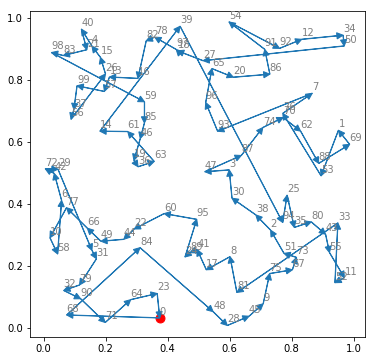

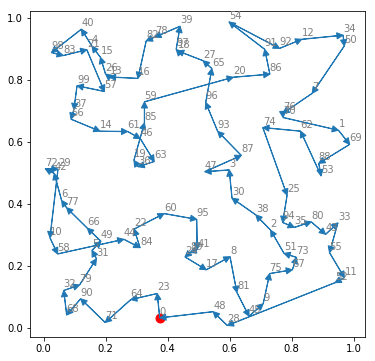

In [14]:
path = tsp_tour(edges)
plot_path(path)
path = tsp_tour(edges, M)
plot_path(path)

## Improvement optimization

In [22]:
# Flip, Or, Two insert OPT
def flip_reverse(path):
    for interval in range(1, len(path)-1):
        for i in range(1, len(path)-1-interval):
            j = i + interval
            sc1 = score(path, i-1, j+1)
            rev = path[i:j+1][::-1]
            copy = np.concatenate([path[:i], rev, path[j+1:]])
            sc2 = score(copy, i-1, j+1)
            if sc1 > sc2:
                path = copy.copy()
                #print('Improved to: ', score(path, 0, len(path)-1))
    return path

def flip_reverse_func(path):
    while True:
        sc1 = score(path, 0, num)
        path = flip_reverse(path)
        sc2 = score(path, 0, num)
        if sc1 == sc2:
            break
    return path

# Or-opt function: Move one city to other place to get better score

def longest(path):
    sc_arr = - np.array([np.sum(np.abs(np.diff(np.array(XY[path[i-1: i+1]])))) for i in range(1, len(path)-1)])
    arg = sc_arr.argsort()    
    return arg

def closest_n(path, n, index):
    copy = path[1:-1].copy()
    if path[index] in copy:
        copy = np.delete(copy, np.where(copy==path[index]))
    d = np.array([np.abs(XY[index] - XY[i]) for i in copy])
    arg = d.argsort()
    closest_index = np.array([copy[i] for i in arg])[:n]
    return closest_index

#@jit('i8[:](i8[:])', parallel=True)
def or_opt(path):
    lon = longest(path)
    #print('Initial Score: ', score(path, 0, num))
    for i in lon:
        sc3 = np.inf
        c5 = closest_n(path, 10, path[i])
        for c in c5:
            j = np.where(path==c)[0][0]
            copy = np.delete(path, i)
            copy = np.insert(copy, j, path[i])
            if i >= j:
                sc1 = score(path, j-1, i+1)
                sc2 = score(copy, j-1, i+1)
            else:
                sc1 = score(path, i-1, j+1)
                sc2 = score(copy, i-1, j+1)
            if sc1 > sc2:
                if sc3 > sc2:
                    sc3 = sc2
                    path = copy.copy()
                    #print('Improved to: ', score(path, 0, len(path)-1))
    return path

# Apply Or-opt to the previous path
def or_opt_func(path):
    while True:
        sc1 = score(path, 0, num)
        path = or_opt(path)
        sc2 = score(path, 0, num)
        if sc1 == sc2:
            break
    return path

def two_insert(path):
    for i in range(1, len(path)-2):
        sc = score(path, 0, num)
        copy = path.copy()
        if type(copy) != list:
            copy = copy.tolist()
        copy.remove(path[i])
        copy.remove(path[i+1])
        sc_best = np.inf
        best_path = path
        for j in range(1, len(copy)):
            p0 = copy[:j] + [path[i]] + [path[i+1]] + copy[j:]
            p1 = copy[:j] + [path[i+1]] + [path[i]] + copy[j:]
            sc0 = score(p0, 0, num)
            sc1 = score(p1, 0, num)
            if sc0 < sc:
                if sc0 < sc_best:
                    best_path = p0
                    sc_best = sc0
                    if sc1 < sc_best:
                        best_path = p1
                        sc_best = sc1
                #print('Improved to: ', score(path, 0, num))
        path = best_path            
    return path

def two_insert_func(path):
    #print('Initial Score:', score(path, 0, num), len(path))
    while True:
        sc1 = score(path, 0, num)
        path = two_insert(path)
        sc2 = score(path, 0, num)
        if sc1 == sc2:
            break
    return path

def flip_or_two_func(path):
    while True:
        sc1 = score(path, 0, num)
        path = flip_reverse_func(path)
        path = or_opt_func(path)
        path = two_insert_func(path)
        sc2 = score(path, 0, num)
        if sc1 == sc2:
            break
    return np.array(path)   

Total Score:  8.429621221103117


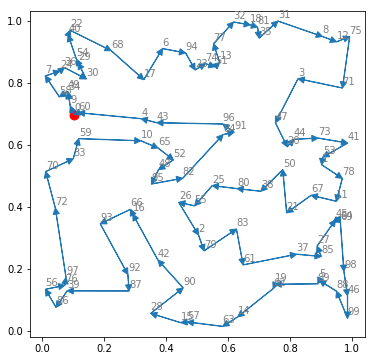

In [23]:
path = flip_or_two_func(path)
plot_path(path)
myscore = score(path, 0, num)

In [18]:
# Opt-n function: Optimize a sequence of cities, n is the number of continuous cities through the path
#@jit('i8[:](i8[:], i4)')
def opt_n(path, n):
    for i in tqdm(range(1, len(path)-n)):
        perm = np.array(path[i:i+n])
        combs = np.array(list(permutations(perm)))
        sc1 = score(path, i-1, i+n+1)
        sc3 = np.inf
        for comb in combs:
            copy = np.concatenate([path[:i], comb, path[i+n:]])
            sc2 = score(copy, i-1, i+n+1)
            if sc1 > sc2:
                if sc3 > sc2:
                    sc3 = sc2
                    path = copy.copy()
                    print('Improved to: ', score(path, 0, len(path)-1))
    return path

# Apply Opt-n to the previous path: n=6(0.9s), n=7 (4.16s), n=8 (25s/43s@100/4m@500), n=9 (3m26s), n=10 (36m)
def opt_n_func(path, n):
    while True:
        sc1 = score(path, 0, num)
        path = opt_n(path, n)
        sc2 = score(path, 0, num)
        if sc1 > sc2:
            path = flip_reverse_func(path)
            path = or_opt_func(path)
        if sc1 == sc2:
            break
    return np.array(path)


Total Score:  8.134694481444091


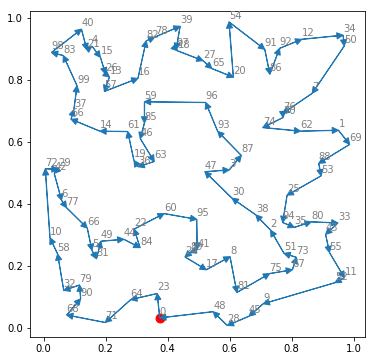

In [19]:
path = opt_n_func(path, 6)
plot_path(path)
myscore = score(path, 0, num)

## Pyconcorde: TSP 
Comparison with Pyconcorde Library

Total Score:  7.936534839976931
7.936534839976931


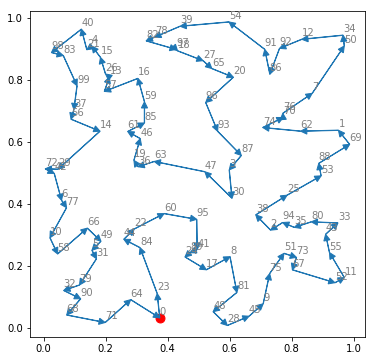

In [20]:
def concorde_tsp(X, Y):
    solver = TSPSolver.from_data(X*10**6, Y*10**6, norm='EUC_2D')
    solution = solver.solve(verbose=True, random_seed=seed)
    #print('Tour Found:', solution.found_tour)
    tour = np.concatenate([solution.tour, [0]])
    return tour

con = concorde_tsp(X, Y)
plot_path(con)
conscore = score(con, 0, num)
print(conscore)

In [35]:
print('Score:', np.round(conscore / myscore*100, 4), '%')

Score: 96.4897 %


In [30]:
N = 100
num = 100
seed = 43
scoreT = 0
scoreM = 0
conscore = 0
for _ in tqdm(range(N)):
    num, path, X, Y, XY = gen_param(num)
    edges = prim(path)
    pathT = tsp_tour(edges)
    pathT = flip_or_two_func(pathT)
    scoreT += score(pathT, 0, num)  
    
    M = min_weight_perfect_matching(edges)
    pathM = tsp_tour(edges, M)
    pathM = flip_or_two_func(pathM) 
    scoreM += score(pathM, 0, num)    
    
    con = concorde_tsp(X, Y)
    conscore += score(con, 0, num)

finalT = scoreT / conscore
finalM = scoreM / conscore
print('Score T:', np.round(finalT*100, 4), '%')
print('Score M:', np.round(finalM*100, 4), '%') 
# Score H: 96.4903 %  (@100: 3m20s)
# Score T: 94.4606 %
# Score M: 97.6185 %


Score T: 105.5888 %
Score M: 102.7978 %


Score T: 94.6251 %
Score M: 97.5625 %
